# Investigating Success in Baseball

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

## Introduction

It is easy to come up with a reasonable expectation about success in baseball. For example, one might expect that successful players will receive higher salaries. But do these expectations always hold? In this analysis, we will investigate such expectations at the team-level.

## Data wrangling

We will use 'Salaries.csv' and 'Teams.csv' for our analysis. 

First, we must modify the salary entries a bit. At the moment, every salary entry reads its nominal value, according to the year in which it was recorded. We need to adjust them for inflation, such that their value represents their worth in 2015, in order to be able to accurately compare salaries between years.

In [2]:
project_dir = '...'

ave_infl = pd.read_table(project_dir + 'inflation.txt', usecols=['YEAR', 'AVE'])
ave_infl = ave_infl.set_index(ave_infl['YEAR'].astype(int))
ave_infl = ave_infl.ix[1986:, 'AVE']/100

def year_to_rate(year):
    ret_rate = 1
    
    if year != 2015:
        for rate in ave_infl.loc[(year + 1):]:
                ret_rate *= (1 + rate)
    
    return ret_rate

salaries = pd.read_csv(project_dir + 'baseball_data\\Salaries.csv')

## the first component of the product maps a particulr year to its respective inflation rate
salaries['salary'] = salaries['yearID'].apply(year_to_rate) * salaries['salary']

Information from inflation.txt was scrapped from the table provided [here](http://www.usinflationcalculator.com/inflation/historical-inflation-rates/), whose values originate from the Bureau of Labor Statistics's [monthly CPI publication](https://www.bls.gov/cpi/home.htm).

**REMARK**: Since entries from 'Salaries.csv' start in 1985, we exclude all entries from other datasets that occurred before. 

In [3]:
teams = pd.read_csv(
    project_dir + 'baseball_data\\Teams.csv',
    dtype={
        'yearID': int,
        'Rank': int, 
        'G': int, 
        'W': int, 
        'L': int
    },
    usecols=[
        'yearID', 
        'lgID', 
        'teamID', 
        'Rank', 
        'G', 
        'W', 
        'L',
        'DivWin', 
        'WCWin', 
        'LgWin', 
        'WSWin',
        'name', 
    ]
)

teams = teams.loc[teams['yearID'] >= 1985, :]

teams['DivWin'] = teams['DivWin'] == 'Y'
teams['WCWin'] = teams['WCWin'] == 'Y'
teams['LgWin'] = teams['LgWin'] == 'Y'
teams['WSWin'] = teams['WSWin'] == 'Y'

In [4]:
teams.shape

(888, 12)

I invoke team's shape attribute so as to have an expected dimension for the cleaned up dataset (called 'orig_data'). 

In [5]:
salaries_grouped = salaries.groupby(['yearID', 'lgID', 'teamID'])

yr_lg_tm_med_sal = {g[0]: g[1]['salary'].median() for g in salaries_grouped}
yr_lg_tm_med_sal = pd.Series(yr_lg_tm_med_sal, name='median_salary')

yr_lg_tm_med_sal.index = yr_lg_tm_med_sal.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_med_sal = yr_lg_tm_med_sal.sort_index()

group_by_list = ['yearID', 'lgID']
teams_grouped = teams.groupby(group_by_list)
columns = [col for col in teams.columns if col not in group_by_list and col != 'teamID']

yr_lg_tm_teams = {}
for g in teams_grouped:
    yr_lg_tm_teams[g[0]] = g[1].set_index('teamID')[columns]
    
yr_lg_tm_teams = pd.concat(yr_lg_tm_teams)
yr_lg_tm_teams.index = yr_lg_tm_teams.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_teams = yr_lg_tm_teams.sort_index()

orig_data = pd.concat([yr_lg_tm_teams, yr_lg_tm_med_sal], axis=1)

In [6]:
orig_data.shape

(890, 10)

Hm. Something must be wrong.

In [7]:
orig_data.loc[orig_data.isnull().any(axis=1), :]

,,,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,name,median_salary
yearID,lgID,teamID,,,,,,,,,,
2014,NL,CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4504500.0
2015,AL,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4875000.0


There are 2 more rows than there should be, so my guess is that these NaN rows are the location of the issue.

In [8]:
idx = pd.IndexSlice

orig_data.loc[idx[2014:2016, :, ['CLE', 'ARI']], :]

Rank      G     W     L DivWin  WCWin  LgWin  WSWin  \
yearID lgID teamID                                                        
2014   AL   CLE      3.0  162.0  85.0  77.0  False  False  False  False   
       NL   ARI      5.0  162.0  64.0  98.0  False  False  False  False   
            CLE      NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN   
2015   AL   ARI      NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            CLE      3.0  161.0  81.0  80.0  False  False  False  False   
       NL   ARI      3.0  162.0  79.0  83.0  False  False  False  False   

                                    name  median_salary  
yearID lgID teamID                                       
2014   AL   CLE        Cleveland Indians    1184516.333  
       NL   ARI     Arizona Diamondbacks    2064562.500  
            CLE                      NaN    4504500.000  
2015   AL   ARI                      NaN    4875000.000  
            CLE        Cleveland Indians    1550000.000  
       NL   ARI     Arizona Diamondbacks     700000.000

It seems that those teams have mislabeled league IDs. For good measure, let's cross-reference these rows with the salaries datset: maybe there's another reason for this occurence.

In [9]:
search_index = (
    ((salaries['yearID'] == 2014) & (salaries['lgID'] == 'NL') & (salaries['teamID'] == 'CLE')) | 
    ((salaries['yearID'] == 2015) & (salaries['lgID'] == 'AL') & (salaries['teamID'] == 'ARI'))
)
salaries.loc[search_index, :]

,yearID,teamID,lgID,playerID,salary
24147,2014,CLE,NL,axforjo01,4504500.0
24781,2015,ARI,AL,reedad01,4875000.0


According to [this page](http://www.baseball-reference.com/players/a/axforjo01.shtml#trans), John Axford signed with the Cleveland Indians that year for that salary; likewise, according to [this page](http://www.baseball-reference.com/players/r/reedad01.shtml#trans), Addison Reed signed with the Arizona Diamondbacks that year for that salary.

So, for both, the issue is a mislabeled lgID entry.

In [10]:
salaries.loc[24147, 'lgID'] = 'AL'
salaries.loc[24781, 'lgID'] = 'NL'

salaries_grouped = salaries.groupby(['yearID', 'lgID', 'teamID'])

yr_lg_tm_med_sal = {g[0]: g[1]['salary'].median() for g in salaries_grouped}
yr_lg_tm_med_sal = pd.Series(yr_lg_tm_med_sal, name='median_salary')

yr_lg_tm_med_sal.index = yr_lg_tm_med_sal.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_med_sal = yr_lg_tm_med_sal.sort_index()

orig_data = pd.concat([yr_lg_tm_teams, yr_lg_tm_med_sal], axis=1)

Some of our datatype conversions were messed up by those NaN entries, so we should fix this.

In [11]:
orig_data.loc[:, ['Rank', 'G', 'W', 'L']] = orig_data.loc[:, ['Rank', 'G', 'W', 'L']].astype(int)

Now let's check for any remaining NaN entries.

In [12]:
orig_data.loc[orig_data.isnull().any(axis=1), :]

,,,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,name,median_salary
yearID,lgID,teamID,,,,,,,,,,


Note that we constructed the dataset with hierarchical indices so that it would be easier concatenate the total salaries with the team dataset. But since there isn't any logic behind the hierarchy, we'll remove it.  

In [13]:
orig_data = pd.DataFrame(orig_data.to_records())

## Success and salary expenditure during the season: how are they related?

There are many ways to measure a team's success. Here, our success measure: takes a collection of game outcomes, where win is assigned to 1, tie is assigned to 0, and loss is assigned to -1; then takes the sum of the assigned values and normalizes it.

In [14]:
df = pd.concat(
    [orig_data[['yearID', 'lgID', 'teamID', 'name', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'median_salary']], 
     pd.Series((orig_data['W'] - orig_data['L'])/orig_data['G'], name='success')],
    axis=1
)

To investigate the relationship between success and salary expenditure, we should consider finding the correlation between the two variables. With this objective, we ask ourselves a few questions. Are we looking for a specific type of relationship (i.e., linear)? Do we wish to support any measurement of correlation with a test?

In this analysis, we will investigate several types of relationship and, if possible, will support any measurement of correlation with a test.

### Pearson's r

Inferential methods testing Pearson's r [assume that the data comes from a normally distributed population](http://www.sjsu.edu/faculty/gerstman/StatPrimer/correlation.pdf). Accordingly we start by assessing the normality of median_salary and success.

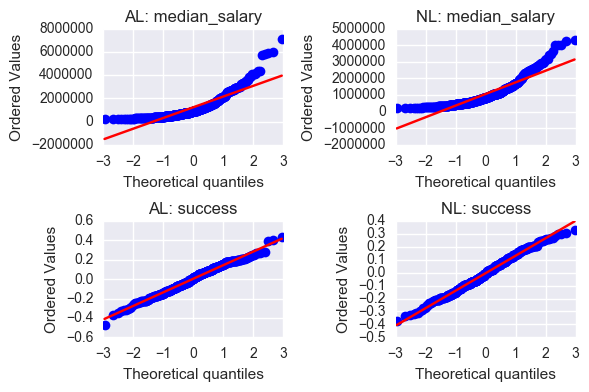

In [15]:
by_lgID = df.groupby('lgID')

gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

stats.probplot(by_lgID.get_group('AL')['median_salary'], plot=ax1)
stats.probplot(by_lgID.get_group('NL')['median_salary'], plot=ax2)
stats.probplot(by_lgID.get_group('AL')['success'], plot=ax3)
stats.probplot(by_lgID.get_group('NL')['success'], plot=ax4)

ax1.title.set_text('AL: median_salary')
ax2.title.set_text('NL: median_salary')
ax3.title.set_text('AL: success')
ax4.title.set_text('NL: success')

plt.tight_layout()

plt.show()

median_salary clearly appears non-normal. But what if we perform a log-transformation?

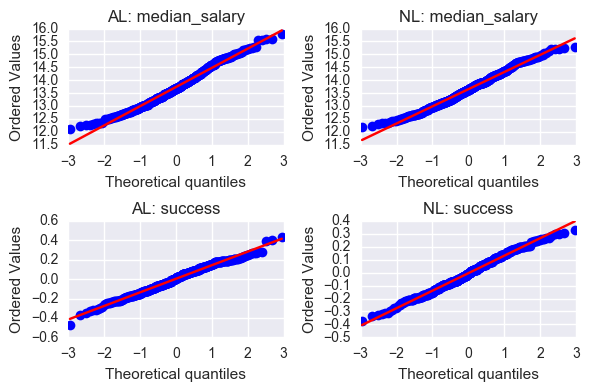

In [16]:
df['(log) median_salary'] = orig_data['median_salary'].apply(np.log)


gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

stats.probplot(by_lgID.get_group('AL')['(log) median_salary'], plot=ax1)
stats.probplot(by_lgID.get_group('NL')['(log) median_salary'], plot=ax2)
stats.probplot(by_lgID.get_group('AL')['success'], plot=ax3)
stats.probplot(by_lgID.get_group('NL')['success'], plot=ax4)

ax1.title.set_text('AL: median_salary')
ax2.title.set_text('NL: median_salary')
ax3.title.set_text('AL: success')
ax4.title.set_text('NL: success')

plt.tight_layout()

plt.show()

These graphs suggest that both variables come from a normally distributed population.

Pearson's r is not robust against outliers, so we'll check for their presence next.

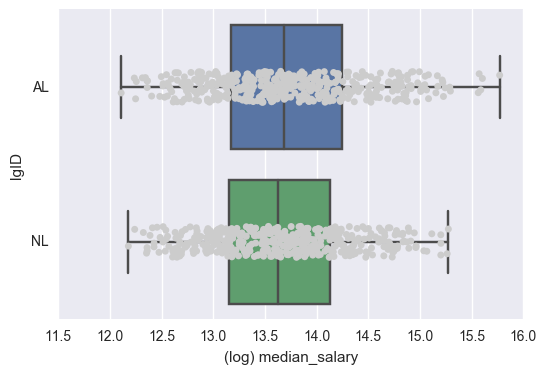

In [17]:
by_lgID = df.groupby('lgID')

sns.stripplot(x='(log) median_salary', y='lgID', jitter=True, color='0.8', data=df, orient='h')
sns.boxplot(x='(log) median_salary', y='lgID', data=df, orient="h")

plt.show()

There do not appear to be any outliers.

Thus, with variables, we can test Pearson's r.

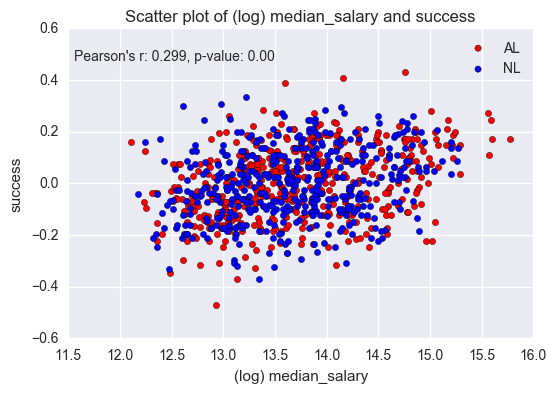

In [18]:
df['(log) median_salary'] = df['median_salary'].apply(np.log)

ax = by_lgID.get_group('AL').plot.scatter(x='(log) median_salary', y='success', color='Red', label='AL')

by_lgID.get_group('NL').plot.scatter(x='(log) median_salary', y='success', color='Blue', label='NL', ax=ax)

r = stats.pearsonr(df['(log) median_salary'], df['success'])

plt.figtext(
    x=0.135, 
    y=0.82, 
    s='Pearson\'s r: {0}, p-value: {1:.2f}'.format(round(r[0], 3), r[1])
)

plt.title('Scatter plot of (log) median_salary and success')

plt.show()

So success and log-transformed median salary have a statistically significant weak, positive linear correlation.

### Spearman's $\rho$
Let's return to the non-transformed median salary data and measure the correlation between success and median salary with Spearman's $\rho$. Compared with Pearson's r—which assumes that the variables come from a normally distributed population and can be described linearly—Spearman's $\rho$ can be regarded as a less restrictive measure of correlation, as it only evaluates the monotonic relationship between variables; it make no assumption about the rate at which two variables change with respect to one another.

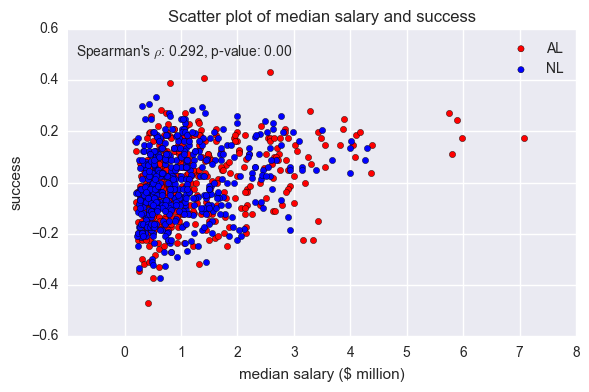

In [19]:
ax = by_lgID.get_group('AL').plot.scatter(x='median_salary', y='success', color='Red', label='AL')

by_lgID.get_group('NL').plot.scatter(x='median_salary', y='success', color='Blue', label='NL', ax=ax)

r = stats.spearmanr(df['median_salary'], df['success'])

plt.figtext(
    x=0.135, 
    y=0.85, 
    s='Spearman\'s ' + r'$\rho$: {0}, p-value: {1:.2f}'.format(round(r[0], 3), r[1])
)

ax.set_xticks([i * 1.0e6 for i in range(0, 9)])
ax.set_xticklabels([str(i) for i in range(0, 9)])

ax.set_xlabel('median salary ($ million)')
plt.title('Scatter plot of median salary and success')

plt.tight_layout()

plt.show()

Thus, there is a statistically significant weak, positive monotonic relationship between median_salary and success. 

## Is the median salary of those teams that go to the playoffs higher than the rest?

In [20]:
df['playoffs?'] = None
df.loc[(df['DivWin'] | df['WCWin']), 'playoffs?'] = True
df.loc[~(df['DivWin'] | df['WCWin']), 'playoffs?'] = False

If possible, we'll perform some statistical test. 

A crucial assumption of nearly every test is that all observations are independent. As a result, we can't use the entire dataset, since the team composition isn't unique between years. To fix this we could create a function that works in such a way as to gather a set of uniquely composed team. But first we need to check if there's any trend in the median salary over 1985-2015. Why? Suppose we design a function which randomly selects two yearID-teamID pairs: (1985, CHC) (2014, ATL). Suppose further that the median player salary for CHC is \$800K and \$2.5M for ATL, and that ATL made it to the playoffs but not CHC. If we were to conduct, say, a Mann-Whitney U test with two groups whose elements behave similarly to these choices of pairs, the result would likely favor the hypothesis that playoff teams are more likely to have higher expenditure on salary. However, the reality may be that this difference in expenditure is explained by the fact that baseball players, even after adjusting for inflation, are paid more in 2014 than 1985. In other words, yearID confounds our interpretation of the test's results.

**REMARK ABOUT DATA FOR GRAPHS BELOW**: We must exclude all data from 1994, since a strike ended the season before the playoffs could take place.

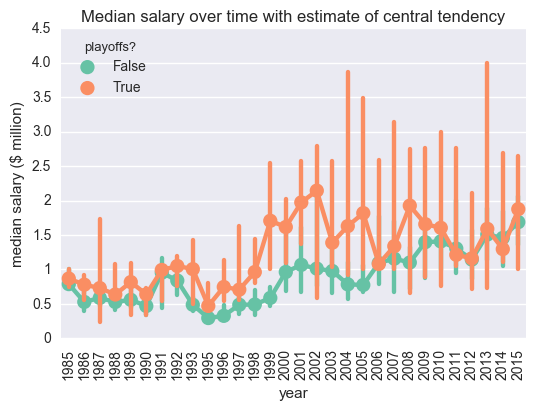

In [21]:
p = sns.pointplot(data=df.loc[df['yearID'] != 1994, :],
                  x='yearID', y='median_salary', hue='playoffs?', palette='Set2', 
                  estimator=np.median)

p.set_xticklabels([y for y in range(1985, 2016) if y != 1994], rotation=90)
p.set_xlabel('year')

p.set_yticks([0, 5.0e5, 1.0e6, 1.5e6, 2.0e6, 2.5e6, 3.0e6, 3.5e6, 4.0e6, 4.5e6])
p.set_yticklabels([0, .500, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0, 4.5])
p.set_ylabel('median salary ($ million)')

plt.title('Median salary over time with estimate of central tendency')

plt.show()

As this graph shows, there is a two-fold issue: an increasing trend in not only median player salaries but also variance in within-year median salaries. Both trends introduce confounds for which none of our tests at the moment can account. 

Despite a lack of test-related conclusion, we can still give an answer, albeit observational, to this question: there do appear to be several years where the mean player salary for playoff teams is much higher than non-playoff teams.

## Do World Series winners have a better seasonal record than other playoff teams?

In [22]:
playoffs_df = df.loc[df['playoffs?'], :]

For this section, we will use a Mann-Whitney U Test. 

The Mann-Whitney U Test can be interpreted differently—and by extension, its hypotheses set stated differently—depending on whether the shape of each group's distribution is the same (see [here](https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php) for more details). So our immediate goal is to examine the shape of the distribution of success of each group.

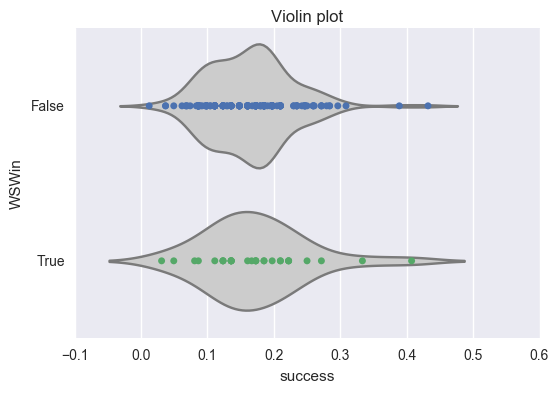

In [23]:
ax_violin = sns.violinplot(x='success', y='WSWin', data=playoffs_df, inner=None, color='.8', orient='h')

ax_violin = sns.stripplot(x='success', y='WSWin', data=playoffs_df, orient='h')

ax_violin.set_xlabel('success')
plt.title('Violin plot')

plt.show()

There is a conspicuous difference in the distributions' shapes. Thus, we can state in words the Mann-Whitney U test hypotheses set:
> H<sub>0</sub>: the probability of a World Series winner's seasonal success being greater than that of another playoff team is equal to 0.5

> H<sub>1</sub>: the probability of a World Series winner's seasonal success being greater than that of another playoff team is not equal to 0.5

More formally,
\begin{align}
&\text{H}_0 : \Pr(x_i > y_j) = 0.5 \\
&\text{H}_1 : \Pr(x_i > y_j) \neq 0.5
\end{align}
for any pairwise comparison of elements of $\{x_1,...,x_n\}$ and $\{y_1,...,y_m\}$.

As mentioned before, our data is not entirely suitable for testing: the fact that team compositions are not unique violates the assumption of independent observations. To fix this, we create a function which finds (yearID, teamID) pairs in such a way that, for any $(y_i, t_i), (y_j, t_j)$ in our sample (such that $i \neq j$), no player on $t_i$ during $y_i$ is on $t_j$ during $y_j$.

In [24]:
def ind_obs_indexer(random_state=1, size=20):
    '''
    Randomly chooses a year_team pair from a set of available year_team pairs in such a way that the team composition
    is unique for every pair.
    
    Returns a list of indices corresponding to the randomly chosen year_team pairs for playoffs_df.
    '''
    rs = np.random.RandomState(random_state)
    
    # initializes all sets necessary for future operations
    WSWin_year_team_set = set(zip(playoffs_df.loc[playoffs_df['WSWin'], 'yearID'], 
                                  playoffs_df.loc[playoffs_df['WSWin'], 'teamID']))
    not_WSWin_year_team_set = set(zip(playoffs_df.loc[~playoffs_df['WSWin'], 'yearID'], 
                                      playoffs_df.loc[~playoffs_df['WSWin'], 'teamID']))
    remaining_choices = WSWin_year_team_set | not_WSWin_year_team_set
    
    chosen_WSWin = set()
    chosen_not_WSWin = set()
    
    # chooses from WSWin_year_team_set
    while(len(chosen_WSWin) <= size):
        intersect = remaining_choices & WSWin_year_team_set
        if len(intersect) == 0:
            if len(chosen_WSWin) <= size:
                return False
            else:
                break
        
        # randomly choice a (year, team) pair from remaining choices of WSWin teams 
        WSWin_year_team = list(intersect)[rs.choice(len(intersect), 1)[0]]
        chosen_WSWin = chosen_WSWin | set([WSWin_year_team])
        
        # puts all players on that team during that year into a set
        index = ((salaries['yearID'] == WSWin_year_team[0]) &
                 (salaries['teamID'] == WSWin_year_team[1]))
        players = set(salaries.loc[index, 'playerID'])
        
        # removes all (year, team) pairs of which at least one player from 'players' was a member
        players_year_team = set(zip(salaries.loc[salaries['playerID'].isin(players), 'yearID'],
                                    salaries.loc[salaries['playerID'].isin(players), 'teamID']))
        remaining_choices = remaining_choices - set(players_year_team)
    
    # chooses from chosen_not_WSWin
    while(True):
        intersect = remaining_choices & not_WSWin_year_team_set
        if len(intersect) == 0:
            if len(chosen_not_WSWin) <= size:
                return False
            else:
                break
                
        # randomly choose a (year, team) pair from remaining choices of not WSWin teams 
        not_WSWin_year_team = list(intersect)[rs.choice(len(intersect), 1)[0]]
        chosen_not_WSWin = chosen_not_WSWin | set([not_WSWin_year_team])

        # puts all players on that team during that year into a set
        index = ((salaries['yearID'] == not_WSWin_year_team[0]) &
                 (salaries['teamID'] == not_WSWin_year_team[1]))
        players = set(salaries.loc[index, 'playerID'])
        
        # removes all (year, team) pairs of which at least one player from 'players' was a member
        players_year_team = set(zip(salaries.loc[salaries['playerID'].isin(players), 'yearID'],
                                    salaries.loc[salaries['playerID'].isin(players), 'teamID']))
        remaining_choices = remaining_choices - set(players_year_team)   

    chosen_year_teams = chosen_WSWin | chosen_not_WSWin
        
    def to_index(arg_set):
        # maps each (yearID, teamId) item from arg_set to corresponding index in playoffs_df
        dictionary = {}

        iterator = playoffs_df[['yearID', 'teamID']].copy()
        iterator['index'] = playoffs_df.index

        for x in iterator.values:
            key = tuple(x[:-1])
            if key in dictionary.keys():
                dictionary[key].append(x[-1])
            else:
                dictionary[key] = x[-1]

        return list(map(lambda x: dictionary[(x[0], x[1])], arg_set))

    to_index(chosen_year_teams)
    
    return to_index(chosen_year_teams)

In [25]:
i = 20
indices = None
while (True):
    indices = ind_obs_indexer(size=i)   
    if indices:
        break
    i = (i - 1) % 20
    
df_mann = playoffs_df.loc[indices, :]

results = stats.mannwhitneyu(
    x=df_mann.loc[df_mann['WSWin'], 'success'],
    y=df_mann.loc[~df_mann['WSWin'], 'success'],
    alternative='two-sided'
)

print('U={0}, p-value={1}'.format(results[0], results[1]))

U=57.0, p-value=0.7286693188215881


At significance level $\alpha = 0.05$, we fail to reject the null hypothesis. Thus, there is statistically significant evidence to be able to conclude that the seasonal success of World Series winners is equal in probability to the seasonal success of other playoff participants.